/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2518 - loss: 1.5618 - val_accuracy: 0.2518 - val_loss: 1.4201
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2616 - loss: 1.4068 - val_accuracy: 0.2838 - val_loss: 1.3882
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3074 - loss: 1.3810 - val_accuracy: 0.3384 - val_loss: 1.3788
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3406 - loss: 1.3705 - val_accuracy: 0.3459 - val_loss: 1.3703
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3621 - loss: 1.3568 - val_accuracy: 0.3473 - val_loss: 1.3614
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3573 - loss: 1.3486 - val_accuracy: 0.3542 - val_loss: 1.3493
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3625 - loss: 1.3374 - val_accuracy: 0.3562 - val_loss: 1.3342
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3734 - loss: 1.3159 - val_accuracy: 0.371

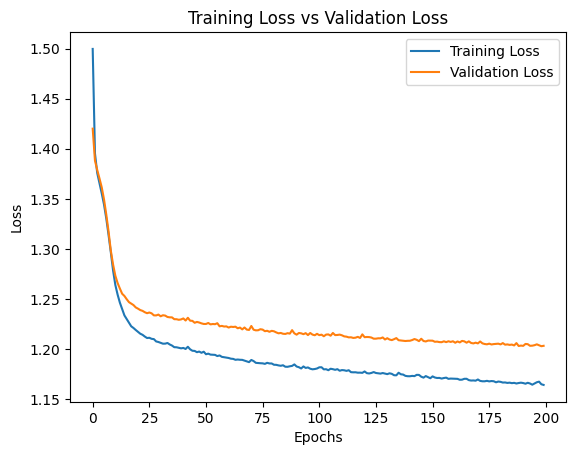

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[[384  77 142 154]
 [237 109 250  90]
 [133  82 384  87]
 [207  45  65 465]]
              precision    recall  f1-score   support

           0       0.40      0.51      0.45       757
           1       0.35      0.16      0.22       686
           2       0.46      0.56      0.50       686
           3       0.58      0.59      0.59       782

    accuracy                           0.46      2911
   macro avg       0.45      0.46      0.44      2911
weighted avg       0.45      0.46      0.44      2911



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
[2]
['C']


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pylab as plt

customer_df = pd.read_csv('customers.csv')


customer_df_cleaned = customer_df.dropna(axis=0)

categories_list = [['Male', 'Female'],
                   ['No', 'Yes'],
                   ['No', 'Yes'],
                   ['Healthcare', 'Engineer', 'Lawyer', 'Artist', 'Doctor',
                    'Homemaker', 'Entertainment', 'Marketing', 'Executive'],
                   ['Low', 'Average', 'High']]

enc = OrdinalEncoder(categories=categories_list)
customers_1 = customer_df_cleaned.copy()
customers_1[['Gender',
             'Ever_Married',
             'Graduated', 'Profession',
             'Spending_Score']] = enc.fit_transform(customers_1[['Gender',
                                                                   'Ever_Married',
                                                                   'Graduated', 'Profession',
                                                                   'Spending_Score']])
le = LabelEncoder()
customers_1['Segmentation'] = le.fit_transform(customers_1['Segmentation'])

customers_1 = customers_1.drop('ID', axis=1)
customers_1 = customers_1.drop('Var_1', axis=1)

# Splitting the dataset into features and target variable
X = customers_1[['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size']].values
y1 = customers_1[['Segmentation']].values


one_hot_enc = OneHotEncoder()
one_hot_enc.fit(y1)
y = one_hot_enc.transform(y1).toarray()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=50)


scaler_age = MinMaxScaler()
scaler_age.fit(X_train[:, 2].reshape(-1, 1))
X_train_scaled = np.copy(X_train)
X_test_scaled = np.copy(X_test)
X_train_scaled[:, 2] = scaler_age.transform(X_train[:, 2].reshape(-1, 1)).reshape(-1)
X_test_scaled[:, 2] = scaler_age.transform(X_test[:, 2].reshape(-1, 1)).reshape(-1)


updated_model = Sequential([
    Dense(10, input_shape=(8,), activation='relu'),
    Dense(16, activation='relu'),
    Dense(24, activation='relu'),
    Dense(4, activation='softmax')
])


updated_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])


history = updated_model.fit(x=X_train_scaled, y=y_train,
                            epochs=200, batch_size=256,
                            validation_data=(X_test_scaled, y_test))


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.show()

y_pred = updated_model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes))


updated_model.save('customer_classification_model_updated.h5')
with open('customer_data_updated.pickle', 'wb') as fh:
    pickle.dump([X_train_scaled, y_train, X_test_scaled, y_test, customers_1, customer_df_cleaned, scaler_age, enc, one_hot_enc, le], fh)


updated_model_loaded = load_model('customer_classification_model_updated.h5')
with open('customer_data_updated.pickle', 'rb') as fh:
    [X_train_scaled, y_train, X_test_scaled, y_test, customers_1, customer_df_cleaned, scaler_age, enc, one_hot_enc, le] = pickle.load(fh)

x_single_prediction = np.argmax(updated_model_loaded.predict(X_test_scaled[1:2, :]), axis=1)
print(x_single_prediction)
print(le.inverse_transform(x_single_prediction))
